In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from utils import graph_overfit

import numpy as np
import pandas as pd
import dill as pkl
import os
import matplotlib.pyplot as plt
import tqdm

import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

torch.manual_seed(seed=73)
np.random.seed(seed=73)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
X_train = np.load(os.path.join('data', 'X_train_transformed.npy'), allow_pickle=True)
y_train = np.load(os.path.join('data', 'y_train.pkl'), allow_pickle=True)
X_test = np.load(os.path.join('data', 'X_test_transformed.npy'), allow_pickle=True)
y_test = np.load(os.path.join('data', 'y_test.pkl'), allow_pickle=True)

# features
X_tensor = torch.tensor(X_train.astype(np.float32))
X_test_tensor = torch.tensor(X_test.astype(np.float32))


# happy, angry, relaxed, sad
y_train -= 1
y_tensor = torch.tensor(y_train.values).type(torch.LongTensor)
y_test -= 1
y_test_tensor = torch.tensor(y_test.values).type(torch.LongTensor)


# binary labels
y_train_arousal = np.array(y_train == 0, dtype=float) + np.array(y_train == 1, dtype=float)  # happy + angry, 0: not aroused, 1: aroused
y_train_arousal_tensor = torch.tensor(y_train_arousal).type(torch.float)

y_train_valence = np.array(y_train == 0, dtype=float) + np.array(y_train == 3, dtype=float)  # happy + relaxed, 0: negative, 1: positive
y_train_valence_tensor = torch.tensor(y_train_valence).type(torch.float)

y_test_arousal = np.array(y_test == 0, dtype=float) + np.array(y_test == 1, dtype=float)  # happy + angry, 0: not aroused, 1: aroused
y_test_arousal_tensor = torch.tensor(y_test_arousal).type(torch.float)

y_test_valence = np.array(y_test == 0, dtype=float) + np.array(y_test == 3, dtype=float)  # happy + relaxed, 0: negative, 1: positive
y_test_valence_tensor = torch.tensor(y_test_valence).type(torch.float)

In [ ]:
train_data_arousal = TensorDataset(X_tensor, y_train_arousal_tensor)
train_data_valence = TensorDataset(X_tensor, y_train_valence_tensor)

test_data_arousal = TensorDataset(X_test_tensor, y_test_arousal_tensor)
test_data_valence = TensorDataset(X_test_tensor, y_test_valence_tensor)

train_loader_arousal = DataLoader(train_data_arousal,
                                    shuffle=True,
                                    batch_size=32,
                                    num_workers=0)
train_loader_valence = DataLoader(train_data_valence,
                                    shuffle=True,
                                    batch_size=32,
                                    num_workers=0)

test_loader_arousal = DataLoader(test_data_arousal,
                                    shuffle=True,
                                    batch_size=32,
                                    num_workers=0)
test_loader_valence = DataLoader(test_data_valence,
                                    shuffle=True,
                                    batch_size=32,
                                    num_workers=0)

In [ ]:
train_data = TensorDataset(X_tensor, y_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_data,
                        shuffle=True,
                        batch_size=32,
                        num_workers=0)

test_loader = DataLoader(test_data,
                        shuffle=True,
                        batch_size=16,
                        num_workers=0)

In [ ]:
def custom_cv_folds(fold_ids):
    fold_ids = np.array(fold_ids, dtype=object)
    for n in range(len(fold_ids)):
        all_ids = list(range(len(fold_ids)))
        all_ids.remove(n)
        yield np.concatenate(fold_ids[all_ids]), fold_ids[n]

In [ ]:
def plot_training(train_vals, test_vals, base_vals):
    fig, axs = plt.subplots(3,1, figsize=(10, 15))
    titles = ['Loss', 'Accuracy', 'Revenue']
    for n, (title, train, test, base) in enumerate(zip(titles, train_vals, test_vals, base_vals)):
        axs[n].plot(train, label='train')
        axs[n].plot(test, label='test')
        #axs[n].plot(base, label='base')
        axs[n].set_title(title)
        axs[n].legend()

    plt.legend()
    plt.show()

In [ ]:
def calculate_revenue(predictions, targets, cost_matrix= torch.tensor([
                                                        [5, -5, -5, 2],
                                                        [-5, 10, 2, -5],
                                                        [-5, 2, 10, -5],
                                                        [2, -5, -2, 5]
                                                        ], device=device)):
    winners = predictions.argmax(dim=1)
    return torch.sum(cost_matrix[targets, winners])

In [ ]:
class CostSensitiveRegularizedLoss(nn.Module):
    def __init__(self, cost_matrix, lambd, reduction='mean'):
        super(CostSensitiveRegularizedLoss, self).__init__()
        self.cost_matrix = (-1.)*cost_matrix
        self.base_loss = torch.nn.CrossEntropyLoss()
        self.lambd = lambd
        self.reduction = reduction
    
    def forward(self, outputs, labels):
        base_l = self.base_loss(outputs, labels)
        cost_l = (self.cost_matrix[labels]*outputs.float()).sum(dim=-1)
        if self.reduction == 'mean':
            total_l = base_l + self.lambd * cost_l.mean()
        elif self.reduction == 'sum':
            total_l = base_l + self.lambd * cost_l.sum()

        return total_l

In [ ]:
class nn_classifier(nn.Module):
    def __init__(self, n_features=99):
        super(nn_classifier, self).__init__()

        self.input_layer = nn.Linear(n_features, 128)
        self.input_activation = nn.SELU()

        self.hidden_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.AlphaDropout(p=0.1),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.AlphaDropout(p=0.1),
            nn.Linear(32,1)
        )

        self.output_layer = nn.Sigmoid()

    def forward(self, x):
        x = self.input_activation(self.input_layer(x))
        x = self.hidden_layers(x)
        output = self.output_layer(x)
        return output[:,0]

In [ ]:
class BaselineClassifier(nn.Module):
    def __init__(self, y):
        super(BaselineClassifier, self).__init__()
        self.prediction = torch.mode(y)[0]

    def forward(self, x):
        output = torch.zeros((len(x), 4))
        output[:, self.prediction] = 1.
        return output

In [ ]:
def train(model: nn.Module, data_loader: DataLoader, optimizer: torch.optim.Optimizer, loss_function: nn.modules.loss, device: torch.device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    revenue = 0

    for data in data_loader:
        inp, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(inp)

        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss

        winners = output > 0.5
        correct += torch.sum((winners == target))
        total += len(target)
        #revenue += calculate_revenue(output, target)

    #out_loss = running_loss / len(data_loader)

    accuracy = correct.float() / float(total)
    out_loss = running_loss

    return out_loss , accuracy, revenue


def evaluate(model: nn.Module, data_loader: DataLoader, loss_function: nn.modules.loss, device: torch.device):
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        correct = 0
        total = 0
        revenue = 0

        for data in data_loader:
            inp, target = data[0].to(device), data[1].to(device)
            output = model(inp)
            loss = loss_function(output, target)

            running_loss += loss

            winners = torch.round(output)
            correct += torch.sum((winners == target))
            total += len(target)
            #revenue += calculate_revenue(output, target)

        #out_loss = running_loss/len(data_loader)
        accuracy = correct.float() / float(total)
        out_loss = running_loss

    return out_loss , accuracy, revenue

In [ ]:
"""
cost_matrix_np = np.array([
    [5, -5, -5, 2],
    [-5, 10, 2, -5],
    [-5, 2, 10, -5],
    [2, -5, -2, 5]
    ])

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], device=device)

scaler = MinMaxScaler()
cost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))
#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))
"""

'\ncost_matrix_np = np.array([\n    [5, -5, -5, 2],\n    [-5, 10, 2, -5],\n    [-5, 2, 10, -5],\n    [2, -5, -2, 5]\n    ])\n\ncost_matrix = torch.tensor([\n        [5, -5, -5, 2],\n        [-5, 10, 2, -5],\n        [-5, 2, 10, -5],\n        [2, -5, -2, 5]\n        ], device=device)\n\nscaler = MinMaxScaler()\ncost_matrix_transformed = torch.Tensor(scaler.fit_transform(cost_matrix_np))\n#cost_matrix_transformed = torch.nn.functional.normalize(torch.Tensor(cost_matrix))\n'

In [ ]:
cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)
0.3281 * sum(cost_matrix[y_test_tensor, y_test_tensor])

tensor(1660.1860)

############# Epoch:0 ###############
Training Loss: 34.56	Training accuracy: 0.55
Test Loss: 14.53	Test accuracy: 0.62
############# Epoch:25 ###############
Training Loss: 34.13	Training accuracy: 0.58
Test Loss: 14.46	Test accuracy: 0.62
############# Epoch:50 ###############
Training Loss: 34.25	Training accuracy: 0.56
Test Loss: 14.41	Test accuracy: 0.64
############# Epoch:75 ###############
Training Loss: 34.01	Training accuracy: 0.56
Test Loss: 14.33	Test accuracy: 0.65
############# Epoch:100 ###############
Training Loss: 33.52	Training accuracy: 0.59
Test Loss: 14.29	Test accuracy: 0.65
############# Epoch:125 ###############
Training Loss: 33.54	Training accuracy: 0.57
Test Loss: 14.25	Test accuracy: 0.66
############# Epoch:150 ###############
Training Loss: 33.82	Training accuracy: 0.57
Test Loss: 14.15	Test accuracy: 0.67
############# Epoch:175 ###############
Training Loss: 33.42	Training accuracy: 0.60
Test Loss: 14.10	Test accuracy: 0.68
############# Epoch:200 #####

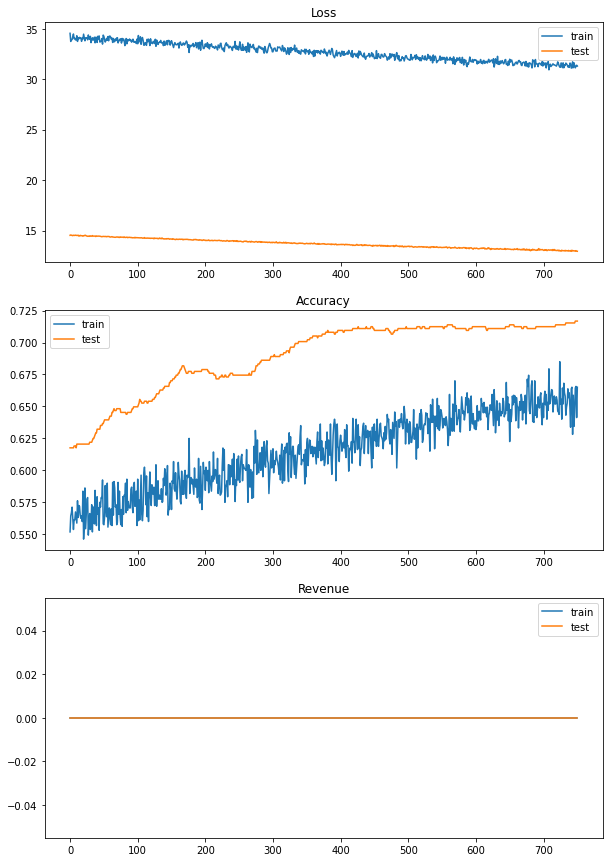

############# Epoch:775 ###############
Training Loss: 30.93	Training accuracy: 0.67
Test Loss: 12.90	Test accuracy: 0.72
############# Epoch:800 ###############
Training Loss: 31.17	Training accuracy: 0.65
Test Loss: 12.90	Test accuracy: 0.72
############# Epoch:825 ###############
Training Loss: 31.22	Training accuracy: 0.66
Test Loss: 12.89	Test accuracy: 0.72
############# Epoch:850 ###############
Training Loss: 30.84	Training accuracy: 0.67
Test Loss: 12.88	Test accuracy: 0.72
############# Epoch:875 ###############
Training Loss: 30.49	Training accuracy: 0.68
Test Loss: 12.79	Test accuracy: 0.72
############# Epoch:900 ###############
Training Loss: 30.50	Training accuracy: 0.68
Test Loss: 12.72	Test accuracy: 0.71
############# Epoch:925 ###############
Training Loss: 30.44	Training accuracy: 0.67
Test Loss: 12.74	Test accuracy: 0.71
############# Epoch:950 ###############
Training Loss: 30.78	Training accuracy: 0.66
Test Loss: 12.65	Test accuracy: 0.71
############# Epoch:975 

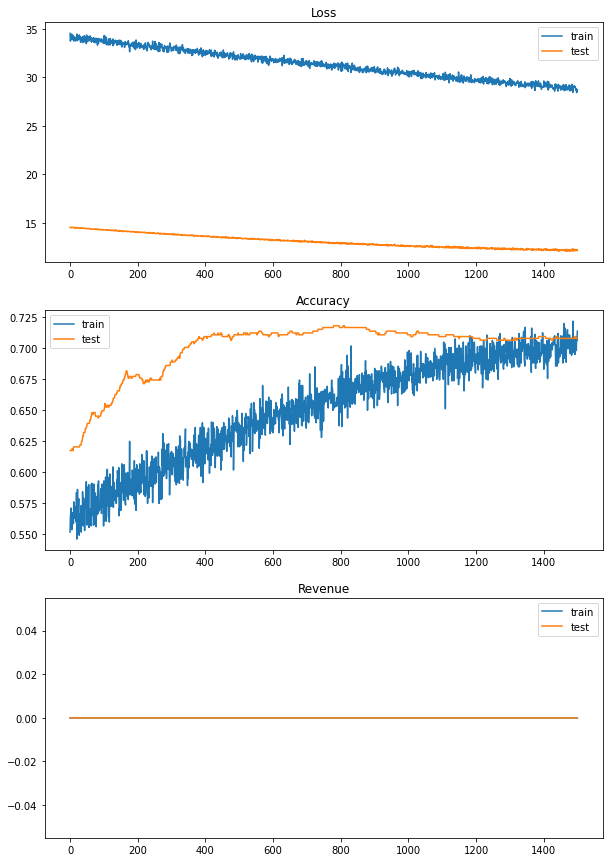

In [ ]:
model_arousal = nn_classifier()
#baseline_clf = BaselineClassifier(y_tensor)
model_arousal.to(device=device)

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

#loss_function = CostLoss(cost_matrix)
#loss_function = CostSensitiveRegularizedLoss(cost_matrix, 2)  # (-1.)*
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()
lr = 1e-7
optimizer = torch.optim.Adam(model_arousal.parameters(), lr=lr)

epochs = 1500
train_losses, train_accs, train_revs = [], [], []
test_losses, test_accs, test_revs = [], [], []
base_losses, base_accs, base_revs = [], [], []

for update in range(epochs):
    train_loss, train_acc, train_rev = train(model_arousal, train_loader_arousal, optimizer, loss_function, device)
    train_losses.append(train_loss.detach())
    train_accs.append(train_acc.detach())
    train_revs.append(train_rev)

    test_loss, test_acc, test_rev = evaluate(model_arousal, test_loader_arousal, loss_function, device)
    test_losses.append(test_loss.detach())
    test_accs.append(test_acc.detach())
    test_revs.append(test_rev)

    #baseline_loss, baseline_acc, baseline_rev = evaluate(baseline_clf, test_arousal_loader, loss_function, device)
    #base_losses.append(baseline_loss)
    #base_accs.append(baseline_acc)
    #base_revs.append(baseline_rev)

    if update % 25 == 0:
        print(f'############# Epoch:{update} ###############')
        print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}')
        print(f'Test Loss: {test_loss:.2f}\tTest accuracy: {test_acc:.2f}')
    
    if update % 750 == 0 and update != 0:
        plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))
    
plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))


############# Epoch:0 ###############
Training Loss: 35.17	Training accuracy: 0.51
Test Loss: 15.12	Test accuracy: 0.57
############# Epoch:50 ###############
Training Loss: 34.11	Training accuracy: 0.56
Test Loss: 14.50	Test accuracy: 0.65
############# Epoch:100 ###############
Training Loss: 33.15	Training accuracy: 0.60
Test Loss: 13.98	Test accuracy: 0.68
############# Epoch:150 ###############
Training Loss: 31.95	Training accuracy: 0.64
Test Loss: 13.66	Test accuracy: 0.68
############# Epoch:200 ###############
Training Loss: 31.60	Training accuracy: 0.65
Test Loss: 13.51	Test accuracy: 0.68
############# Epoch:250 ###############
Training Loss: 31.11	Training accuracy: 0.67
Test Loss: 13.27	Test accuracy: 0.68
############# Epoch:300 ###############
Training Loss: 30.47	Training accuracy: 0.68
Test Loss: 13.21	Test accuracy: 0.68
############# Epoch:350 ###############
Training Loss: 30.29	Training accuracy: 0.70
Test Loss: 13.36	Test accuracy: 0.69
############# Epoch:400 ###

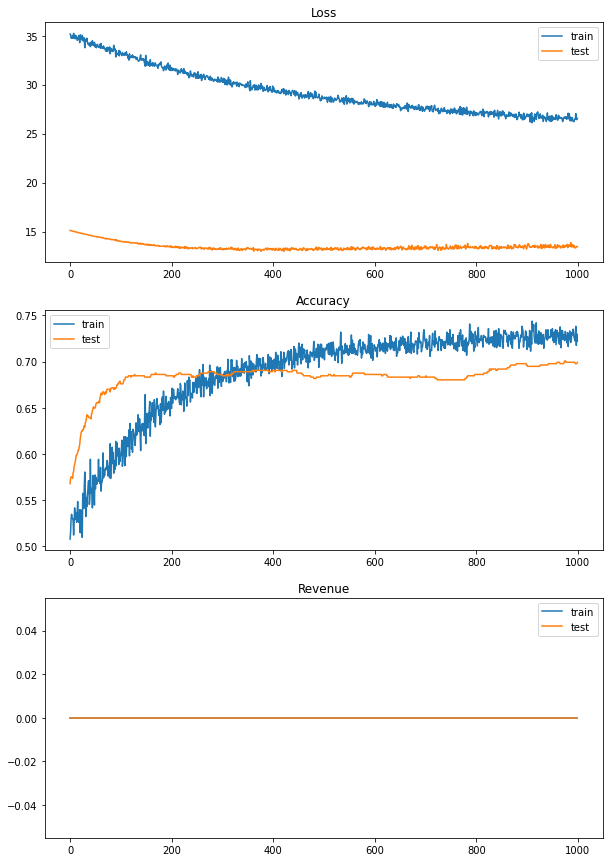

In [ ]:
model_valence = nn_classifier()
#baseline_clf = BaselineClassifier(y_tensor)
model_valence.to(device=device)

cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

#loss_function = CostLoss(cost_matrix)
#loss_function = CostSensitiveRegularizedLoss(cost_matrix, 2)  # (-1.)*
#loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCELoss()
lr = 1e-6
optimizer = torch.optim.Adam(model_valence.parameters(), lr=lr)

epochs = 1000
train_losses, train_accs, train_revs = [], [], []
test_losses, test_accs, test_revs = [], [], []
base_losses, base_accs, base_revs = [], [], []

for update in range(epochs):
    train_loss, train_acc, train_rev = train(model_valence, train_loader_valence, optimizer, loss_function, device)
    train_losses.append(train_loss.detach())
    train_accs.append(train_acc.detach())
    train_revs.append(train_rev)

    test_loss, test_acc, test_rev = evaluate(model_valence, test_loader_valence, loss_function, device)
    test_losses.append(test_loss.detach())
    test_accs.append(test_acc.detach())
    test_revs.append(test_rev)

    #baseline_loss, baseline_acc, baseline_rev = evaluate(baseline_clf, test_arousal_loader, loss_function, device)
    #base_losses.append(baseline_loss)
    #base_accs.append(baseline_acc)
    #base_revs.append(baseline_rev)

    if update % 50 == 0:
        print(f'############# Epoch:{update} ###############')
        print(f'Training Loss: {train_loss:.2f}\tTraining accuracy: {train_acc:.2f}')
        print(f'Test Loss: {test_loss:.2f}\tTest accuracy: {test_acc:.2f}')
    
plot_training((train_losses, train_accs, train_revs), (test_losses, test_accs, test_revs), (base_losses, base_accs, base_revs))

In [ ]:
result_matrix = torch.tensor([
        [0, 1],
        [3, 2]
        ])

with torch.no_grad():
    arousal_pred = (torch.round(model(X_test_tensor)).type(torch.long) == 0).type(torch.long)
    valence_pred = (torch.round(model_valence(X_test_tensor)).type(torch.long) == 0).type(torch.long)
    y_pred = result_matrix[arousal_pred, valence_pred]

sum(cost_matrix[y_test_tensor, y_pred]) / sum(cost_matrix[y_test_tensor, y_test_tensor])

tensor(0.3281)

In [ ]:
sum(y_pred == y_test_tensor) / len(y_test_tensor)

tensor(0.4920)

In [ ]:
result_matrix = torch.tensor([
        [0, 1],
        [3, 2]
        ])

with torch.no_grad():
    arousal_pred = (torch.round(model(X_tensor)).type(torch.long) == 0).type(torch.long)
    valence_pred = (torch.round(model_valence(X_tensor)).type(torch.long) == 0).type(torch.long)
    y_pred = result_matrix[arousal_pred, valence_pred]

sum(cost_matrix[y_train, y_pred]) / sum(cost_matrix[y_train, y_train])

<ipython-input-127-501d714a1268>:11: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  sum(cost_matrix[y_train, y_pred]) / sum(cost_matrix[y_train, y_train])


tensor(0.4125)

In [ ]:
sum(y_pred == y_tensor) / len(y_tensor)

tensor(0.5410)

In [ ]:
arousal_pred.type(torch.long)

tensor([1, 0, 0,  ..., 1, 0, 1])

In [ ]:
cost_matrix = torch.tensor([
        [5, -5, -5, 2],
        [-5, 10, 2, -5],
        [-5, 2, 10, -5],
        [2, -5, -2, 5]
        ], dtype=torch.float, device=device)

In [ ]:
sum(cost_matrix[y_test_tensor, y_pred]) / sum(cost_matrix[y_test_tensor, y_test_tensor])

tensor(0.3150)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e2905743-bdaf-45dd-a896-9824e6125426' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>